In [1]:
!nvidia-smi

Thu Jul 17 08:35:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/hackathon

/content/drive/MyDrive/hackathon


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cell-images-for-detecting-malaria


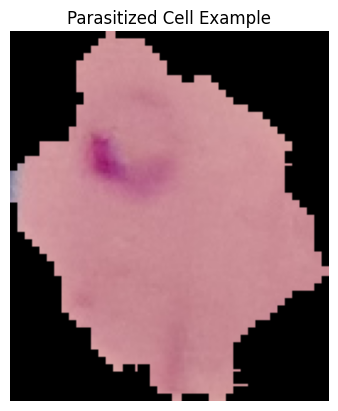

In [10]:

import os
from PIL import Image
import matplotlib.pyplot as plt



parasitized_dir = os.path.join(path, "cell_images", "Parasitized")

image_files = os.listdir(parasitized_dir)

image_files = [f for f in image_files if f.endswith(('.png', '.jpg', '.jpeg'))]

sample_image_path = os.path.join(parasitized_dir, image_files[0])


image = Image.open(sample_image_path)

plt.imshow(image)
plt.title("Parasitized Cell Example")
plt.axis("off")
plt.show()

In [3]:
!pip install ultralytics
!pip install torch torchvision torchaudio
!pip install opencv-python
!pip install matplotlib
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [11]:
import os
import shutil
from pathlib import Path
import random
from ultralytics import YOLO
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [13]:
import os
import shutil
import random
from pathlib import Path

def create_dataset_split(source_dir, output_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """
    Split dataset into train/val/test for YOLOv8 classification
    """
    splits = ['train', 'val', 'test']
    classes = ['Parasitized', 'Uninfected']

    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)
    for cls in classes:
        class_dir = os.path.join(source_dir, cls)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        random.shuffle(images)
        total = len(images)
        train_end = int(total * train_ratio)
        val_end = int(total * (train_ratio + val_ratio))

        train_images = images[:train_end]
        val_images = images[train_end:val_end]
        test_images = images[val_end:]

        for img in train_images:
            shutil.copy2(os.path.join(class_dir, img), os.path.join(output_dir, 'train', cls, img))

        for img in val_images:
            shutil.copy2(os.path.join(class_dir, img), os.path.join(output_dir, 'val', cls, img))

        for img in test_images:
            shutil.copy2(os.path.join(class_dir, img), os.path.join(output_dir, 'test', cls, img))

        print(f"{cls}: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test")

source_directory = f"{path}/cell_images"
output_directory = "malaria_dataset"
create_dataset_split(source_directory, output_directory)

Parasitized: 9645 train, 2756 val, 1378 test
Uninfected: 9645 train, 2756 val, 1378 test


In [ ]:
# from ultralytics import YOLO
# import torch

# def train_malaria_classifier():
#     """
#     Train YOLOv8 classification model for malaria detection
#     """

#     # Check if GPU is available
#     device = 'cuda' if torch.cuda.is_available() else 'cpu'
#     print(f"Using device: {device}")

#     # Load YOLOv8 classification model
#     model = YOLO('yolov8n-cls.pt')  # nano model for faster training
#     # Alternative models: yolov8s-cls.pt, yolov8m-cls.pt, yolov8l-cls.pt, yolov8x-cls.pt

#     # Training parameters
#     results = model.train(
#         data='malaria_dataset',
#         epochs=100,
#         imgsz=224,
#         batch=16,
#         device=device,
#         workers=4,
#         patience=10,
#         save=True,
#         save_period=10,
#         val=True,
#         plots=True,
#         verbose=True,
#         seed=42,

#         # Data augmentation parameters
#         hsv_h=0.015,           # HSV-Hue augmentation
#         hsv_s=0.7,             # HSV-Saturation augmentation
#         hsv_v=0.4,             # HSV-Value augmentation
#         degrees=0.0,           # rotation degrees
#         translate=0.1,         # translation
#         scale=0.5,             # scale
#         shear=0.0,             # shear
#         perspective=0.0,       # perspective
#         flipud=0.0,            # flip up-down
#         fliplr=0.5,            # flip left-right
#         mosaic=0.0,            # mosaic augmentation (not typically used for classification)
#         mixup=0.0,             # mixup augmentation
#         copy_paste=0.0,        # copy-paste augmentation

#         # Optimization parameters
#         optimizer='AdamW',      # optimizer (SGD, Adam, AdamW)
#         lr0=0.001,             # initial learning rate
#         lrf=0.1,               # final learning rate factor
#         momentum=0.937,        # momentum
#         weight_decay=0.0005,   # weight decay
#         warmup_epochs=3,       # warmup epochs
#         warmup_momentum=0.8,   # warmup momentum
#         warmup_bias_lr=0.1,    # warmup bias learning rate

#         # Model parameters
#         dropout=0.0,           # dropout rate

#         # Project organization
#         project='malaria_classification',  # project name
#         name='yolov8_malaria',            # experiment name
#     )

#     return model, results

# # Train the model
# model, results = train_malaria_classifier()

### Simple trainig

In [17]:
from ultralytics import YOLO
import torch

def train_malaria_classifier():
    """
    Train YOLOv8 classification model for malaria detection
    """

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    model = YOLO('yolov8n-cls.pt')

    results = model.train(
    data='/content/drive/MyDrive/hackathon/datasets',
    epochs=100,
    imgsz=224,
    batch=16,
    device=device,
    workers=4,
    patience=10,
    save=True,
    save_period=10,
    val=True,
    plots=True,
    )

    return model, results

model, results = train_malaria_classifier()

Using device: cuda
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/hackathon/datasets, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0,

train: Scanning /content/drive/MyDrive/hackathon/datasets/train... 19290 images, 0 corrupt: 100%|██████████| 19290/19290 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 4.1±6.8 ms, read: 3.1±1.4 MB/s, size: 12.8 KB)


val: Scanning /content/drive/MyDrive/hackathon/datasets/val... 5512 images, 0 corrupt: 100%|██████████| 5512/5512 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/train4
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100     0.277G     0.3759         10        224: 100%|██████████| 1206/1206 [03:37<00:00,  5.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:35<00:00,  4.89it/s]

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


      2/100     0.281G     0.2932         10        224: 100%|██████████| 1206/1206 [03:13<00:00,  6.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:34<00:00,  5.02it/s]

                   all      0.927          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100     0.281G     0.3147         10        224: 100%|██████████| 1206/1206 [03:12<00:00,  6.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:35<00:00,  4.88it/s]

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100     0.281G      0.298         10        224: 100%|██████████| 1206/1206 [03:11<00:00,  6.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:35<00:00,  4.87it/s]

                   all      0.956          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100     0.281G     0.2557         10        224: 100%|██████████| 1206/1206 [03:12<00:00,  6.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:36<00:00,  4.75it/s]

                   all      0.956          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100     0.281G     0.2396         10        224: 100%|██████████| 1206/1206 [03:11<00:00,  6.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [01:18<00:00,  2.22it/s]

                   all      0.959          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100     0.285G     0.2337         10        224: 100%|██████████| 1206/1206 [03:10<00:00,  6.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:35<00:00,  4.82it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100     0.285G     0.2301         10        224: 100%|██████████| 1206/1206 [03:11<00:00,  6.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:35<00:00,  4.92it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100     0.285G     0.2261         10        224: 100%|██████████| 1206/1206 [03:09<00:00,  6.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:34<00:00,  5.00it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100     0.287G      0.208         10        224: 100%|██████████| 1206/1206 [03:12<00:00,  6.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:35<00:00,  4.92it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100     0.291G     0.2111         10        224: 100%|██████████| 1206/1206 [03:11<00:00,  6.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:34<00:00,  4.95it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100     0.291G     0.2019         10        224: 100%|██████████| 1206/1206 [03:10<00:00,  6.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:34<00:00,  5.02it/s]

                   all       0.96          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100     0.291G     0.2073         10        224: 100%|██████████| 1206/1206 [03:13<00:00,  6.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:35<00:00,  4.92it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100     0.291G     0.2028         10        224: 100%|██████████| 1206/1206 [03:11<00:00,  6.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:35<00:00,  4.92it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100     0.291G     0.1971         10        224: 100%|██████████| 1206/1206 [03:11<00:00,  6.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:35<00:00,  4.91it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100     0.291G     0.2007         10        224: 100%|██████████| 1206/1206 [03:12<00:00,  6.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:35<00:00,  4.93it/s]

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100     0.291G     0.1977         10        224: 100%|██████████| 1206/1206 [03:04<00:00,  6.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:33<00:00,  5.18it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100     0.291G     0.1923         10        224: 100%|██████████| 1206/1206 [03:07<00:00,  6.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:34<00:00,  5.08it/s]

                   all      0.964          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100     0.291G     0.1906         10        224: 100%|██████████| 1206/1206 [03:09<00:00,  6.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:36<00:00,  4.74it/s]

                   all      0.965          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100     0.291G     0.1887         10        224: 100%|██████████| 1206/1206 [03:06<00:00,  6.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:38<00:00,  4.53it/s]

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100     0.291G     0.1932         10        224: 100%|██████████| 1206/1206 [03:12<00:00,  6.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:34<00:00,  4.98it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100     0.291G     0.1908         10        224: 100%|██████████| 1206/1206 [03:05<00:00,  6.52it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:35<00:00,  4.94it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100     0.291G     0.1889         10        224: 100%|██████████| 1206/1206 [03:04<00:00,  6.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:35<00:00,  4.93it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100     0.291G     0.1883         10        224: 100%|██████████| 1206/1206 [03:05<00:00,  6.51it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:33<00:00,  5.17it/s]

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


     25/100     0.291G     0.1816         10        224: 100%|██████████| 1206/1206 [03:08<00:00,  6.39it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:35<00:00,  4.94it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100     0.291G     0.1856         10        224: 100%|██████████| 1206/1206 [03:06<00:00,  6.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:33<00:00,  5.09it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


     27/100     0.291G      0.191         10        224: 100%|██████████| 1206/1206 [03:06<00:00,  6.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:33<00:00,  5.11it/s]

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


     28/100     0.291G     0.1805         10        224: 100%|██████████| 1206/1206 [03:06<00:00,  6.48it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:34<00:00,  4.97it/s]

                   all      0.967          1



      Epoch    GPU_mem       loss  Instances       Size


     29/100     0.291G     0.1819         10        224: 100%|██████████| 1206/1206 [03:03<00:00,  6.57it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:34<00:00,  5.00it/s]

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100     0.291G      0.178         10        224: 100%|██████████| 1206/1206 [03:07<00:00,  6.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:33<00:00,  5.13it/s]

                   all      0.969          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100     0.291G     0.1771         10        224: 100%|██████████| 1206/1206 [03:05<00:00,  6.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:33<00:00,  5.19it/s]

                   all      0.969          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100     0.291G     0.1776         10        224: 100%|██████████| 1206/1206 [03:04<00:00,  6.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:36<00:00,  4.79it/s]

                   all      0.969          1
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 22, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



32 epochs completed in 2.014 hours.
Optimizer stripped from runs/classify/train4/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train4/weights/best.pt, 3.0MB

Validating runs/classify/train4/weights/best.pt...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/drive/MyDrive/hackathon/datasets/train... found 19290 images in 2 classes ✅ 
val: /content/drive/MyDrive/hackathon/datasets/val... found 5512 images in 2 classes ✅ 
test: /content/drive/MyDrive/hackathon/datasets/test... found 2756 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:54<00:00,  3.18it/s]


                   all       0.97          1
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train4


In [18]:
def evaluate_model(model_path, test_data_path):
    """
    Evaluate trained model on test set
    """
    # Load trained model
    model = YOLO(model_path)

    # Validate on test set
    results = model.val(data=test_data_path, split='test')

    print(f"Test Accuracy: {results.top1:.4f}")
    print(f"Test Top-5 Accuracy: {results.top5:.4f}")

    return results

In [19]:
test_results = evaluate_model('/content/drive/MyDrive/hackathon/runs/classify/train4/weights/best.pt',
                             '/content/drive/MyDrive/hackathon/datasets')

Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/drive/MyDrive/hackathon/datasets/train... found 19290 images in 2 classes ✅ 
val: /content/drive/MyDrive/hackathon/datasets/val... found 5512 images in 2 classes ✅ 
test: /content/drive/MyDrive/hackathon/datasets/test... found 2756 images in 2 classes ✅ 
test: Fast image access ✅ (ping: 0.4±0.0 ms, read: 8.0±4.5 MB/s, size: 11.6 KB)


test: Scanning /content/drive/MyDrive/hackathon/datasets/test... 2756 images, 0 corrupt: 100%|██████████| 2756/2756 [00:13<00:00, 205.31it/s]


test: New cache created: /content/drive/MyDrive/hackathon/datasets/test.cache


               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:17<00:00,  9.66it/s]


                   all      0.964          1
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val
Test Accuracy: 0.9637
Test Top-5 Accuracy: 1.0000


In [20]:
def create_confusion_matrix(model_path, test_dir):
    """
    Create confusion matrix for the trained model
    """
    model = YOLO(model_path)

    # Get predictions for test set
    test_parasitized = os.path.join(test_dir, 'test', 'Parasitized')
    test_uninfected = os.path.join(test_dir, 'test', 'Uninfected')

    y_true = []
    y_pred = []

    # Process Parasitized images
    for img_name in os.listdir(test_parasitized):
        img_path = os.path.join(test_parasitized, img_name)
        results = model(img_path)
        predicted_class = results[0].names[results[0].probs.top1]
        y_true.append('Parasitized')
        y_pred.append(predicted_class)

    # Process Uninfected images
    for img_name in os.listdir(test_uninfected):
        img_path = os.path.join(test_uninfected, img_name)
        results = model(img_path)
        predicted_class = results[0].names[results[0].probs.top1]
        y_true.append('Uninfected')
        y_pred.append(predicted_class)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=['Parasitized', 'Uninfected'])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Parasitized', 'Uninfected'],
                yticklabels=['Parasitized', 'Uninfected'])
    plt.title('Confusion Matrix - Malaria Classification')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return cm


Streaming output truncated to the last 5000 lines.
image 1/1 /content/drive/MyDrive/hackathon/datasets/test/Parasitized/C119P80ThinF_IMG_20151002_123911_cell_132.png: 224x224 Parasitized 1.00, Uninfected 0.00, 4.4ms
Speed: 2.5ms preprocess, 4.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/drive/MyDrive/hackathon/datasets/test/Parasitized/C175P136NThinF_IMG_20151127_141428_cell_213.png: 224x224 Parasitized 0.86, Uninfected 0.14, 5.5ms
Speed: 2.6ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/drive/MyDrive/hackathon/datasets/test/Parasitized/C136P97ThinF_IMG_20151005_144727_cell_124.png: 224x224 Parasitized 1.00, Uninfected 0.00, 4.2ms
Speed: 2.4ms preprocess, 4.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/drive/MyDrive/hackathon/datasets/test/Parasitized/C82P43ThinF_IMG_20150817_124418_cell_172.png: 224x224 Parasitized 1.00, Uninfected 0.00, 8.9

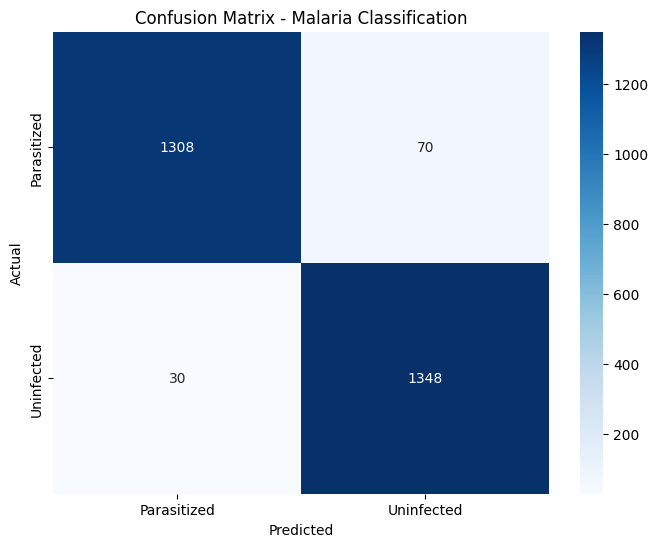

In [21]:
cm = create_confusion_matrix('/content/drive/MyDrive/hackathon/runs/classify/train4/weights/best.pt',
                             '/content/drive/MyDrive/hackathon/datasets')

In [22]:
def predict_single_image(model_path, image_path):
    """
    Predict malaria status for a single image
    """
    model = YOLO(model_path)

    # Make prediction
    results = model(image_path)

    # Get prediction details
    predicted_class = results[0].names[results[0].probs.top1]
    confidence = results[0].probs.top1conf.item()

    print(f"Image: {image_path}")
    print(f"Prediction: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")

    return predicted_class, confidence

In [23]:
prediction, confidence = predict_single_image(
   '/content/drive/MyDrive/hackathon/runs/classify/train4/weights/best.pt',
                             '/content/drive/MyDrive/hackathon/datasets/test/Parasitized/C100P61ThinF_IMG_20150918_145422_cell_165.png')


image 1/1 /content/drive/MyDrive/hackathon/datasets/test/Parasitized/C100P61ThinF_IMG_20150918_145422_cell_165.png: 224x224 Parasitized 1.00, Uninfected 0.00, 14.7ms
Speed: 5.9ms preprocess, 14.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
Image: /content/drive/MyDrive/hackathon/datasets/test/Parasitized/C100P61ThinF_IMG_20150918_145422_cell_165.png
Prediction: Parasitized
Confidence: 1.0000


In [25]:
prediction, confidence = predict_single_image(
   '/content/drive/MyDrive/hackathon/runs/classify/train4/weights/best.pt',
                             '/content/drive/MyDrive/hackathon/datasets/test/Uninfected/C106P67ThinF_IMG_20150924_103245_cell_142.png')


image 1/1 /content/drive/MyDrive/hackathon/datasets/test/Uninfected/C106P67ThinF_IMG_20150924_103245_cell_142.png: 224x224 Uninfected 0.97, Parasitized 0.03, 7.2ms
Speed: 4.4ms preprocess, 7.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
Image: /content/drive/MyDrive/hackathon/datasets/test/Uninfected/C106P67ThinF_IMG_20150924_103245_cell_142.png
Prediction: Uninfected
Confidence: 0.9719


##### Batch Prediction

In [26]:
def batch_predict(model_path, image_folder):
    """
    Predict malaria status for multiple images
    """
    model = YOLO(model_path)

    results = []
    for img_name in os.listdir(image_folder):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(image_folder, img_name)
            prediction = model(img_path)

            predicted_class = prediction[0].names[prediction[0].probs.top1]
            confidence = prediction[0].probs.top1conf.item()

            results.append({
                'image': img_name,
                'prediction': predicted_class,
                'confidence': confidence
            })

    return results

In [27]:
batch_results = batch_predict(
    '/content/drive/MyDrive/hackathon/runs/classify/train4/weights/best.pt',
    '/content/drive/MyDrive/hackathon/datasets/test/Uninfected'
)


image 1/1 /content/drive/MyDrive/hackathon/datasets/test/Uninfected/C237ThinF_IMG_20151127_104844_cell_245.png: 224x224 Uninfected 0.99, Parasitized 0.01, 6.7ms
Speed: 3.9ms preprocess, 6.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/drive/MyDrive/hackathon/datasets/test/Uninfected/C209ThinF_IMG_20151029_160803_cell_127.png: 224x224 Uninfected 1.00, Parasitized 0.00, 5.1ms
Speed: 3.6ms preprocess, 5.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/drive/MyDrive/hackathon/datasets/test/Uninfected/C65P26N_ThinF_IMG_20150818_154050_cell_90.png: 224x224 Uninfected 1.00, Parasitized 0.00, 3.7ms
Speed: 2.6ms preprocess, 3.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/drive/MyDrive/hackathon/datasets/test/Uninfected/C212ThinF_IMG_20151106_110411_cell_166.png: 224x224 Uninfected 1.00, Parasitized 0.00, 4.7ms
Speed: 2.4ms preprocess, 4.7ms inference, 0.0ms postprocess p

In [28]:
batch_results = batch_predict(
    '/content/drive/MyDrive/hackathon/runs/classify/train4/weights/best.pt',
    '/content/drive/MyDrive/hackathon/datasets/test/Parasitized'
)


image 1/1 /content/drive/MyDrive/hackathon/datasets/test/Parasitized/C48P9thinF_IMG_20150721_160406_cell_200.png: 224x224 Parasitized 1.00, Uninfected 0.00, 4.5ms
Speed: 3.0ms preprocess, 4.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/drive/MyDrive/hackathon/datasets/test/Parasitized/C63P24N_ThinF_IMG_20150818_142948_cell_170.png: 224x224 Parasitized 0.97, Uninfected 0.03, 4.1ms
Speed: 2.9ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/drive/MyDrive/hackathon/datasets/test/Parasitized/C137P98ThinF_IMG_20151005_163251_cell_68.png: 224x224 Parasitized 1.00, Uninfected 0.00, 14.2ms
Speed: 2.5ms preprocess, 14.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /content/drive/MyDrive/hackathon/datasets/test/Parasitized/C180P141NThinF_IMG_20151201_164714_cell_191.png: 224x224 Parasitized 1.00, Uninfected 0.00, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 0.0m

🔬 Starting Post-Training Evaluation...
Evaluating on test set...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/drive/MyDrive/hackathon/datasets/train... found 19290 images in 2 classes ✅ 
val: /content/drive/MyDrive/hackathon/datasets/val... found 5512 images in 2 classes ✅ 
test: /content/drive/MyDrive/hackathon/datasets/test... found 2756 images in 2 classes ✅ 
test: Fast image access ✅ (ping: 0.5±0.2 ms, read: 4.9±2.8 MB/s, size: 11.6 KB)


test: Scanning /content/drive/MyDrive/hackathon/datasets/test... 2756 images, 0 corrupt: 100%|██████████| 2756/2756 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 173/173 [00:32<00:00,  5.37it/s]


                   all      0.964          1
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val3
Test Accuracy: 0.9637
Test Loss: 0.9819
Processing Parasitized images...
Processing Uninfected images...


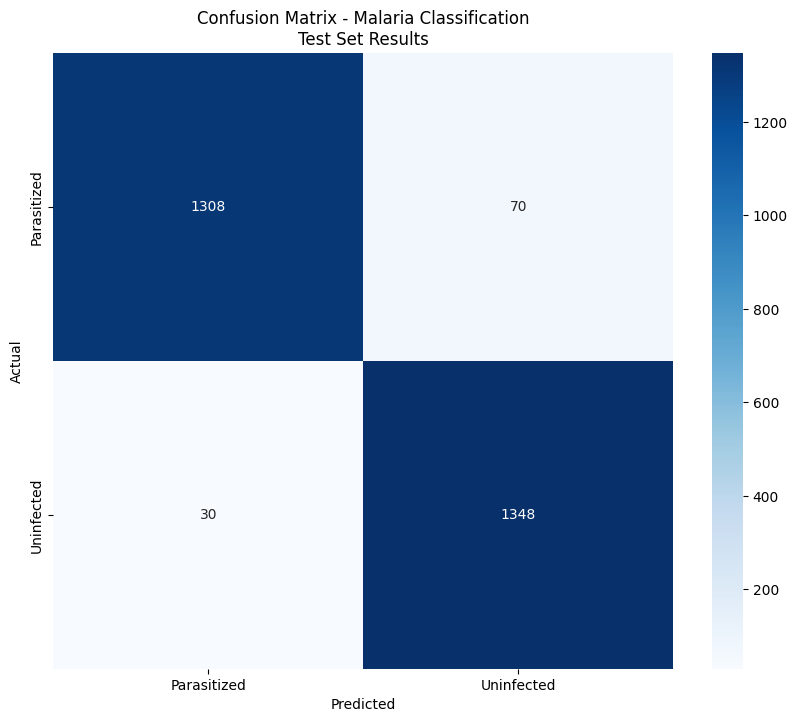


Test Set Metrics:
Accuracy: 0.9637
Precision: 0.9776
Recall: 0.9492
F1-Score: 0.9632
Average Confidence: 0.9574
Available columns in results.csv:
['epoch', 'time', 'train/loss', 'metrics/accuracy_top1', 'metrics/accuracy_top5', 'val/loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
Mapped columns: {'val/acc_top1': 'metrics/accuracy_top1', 'train/loss': 'train/loss', 'lr/pg0': 'lr/pg0'}


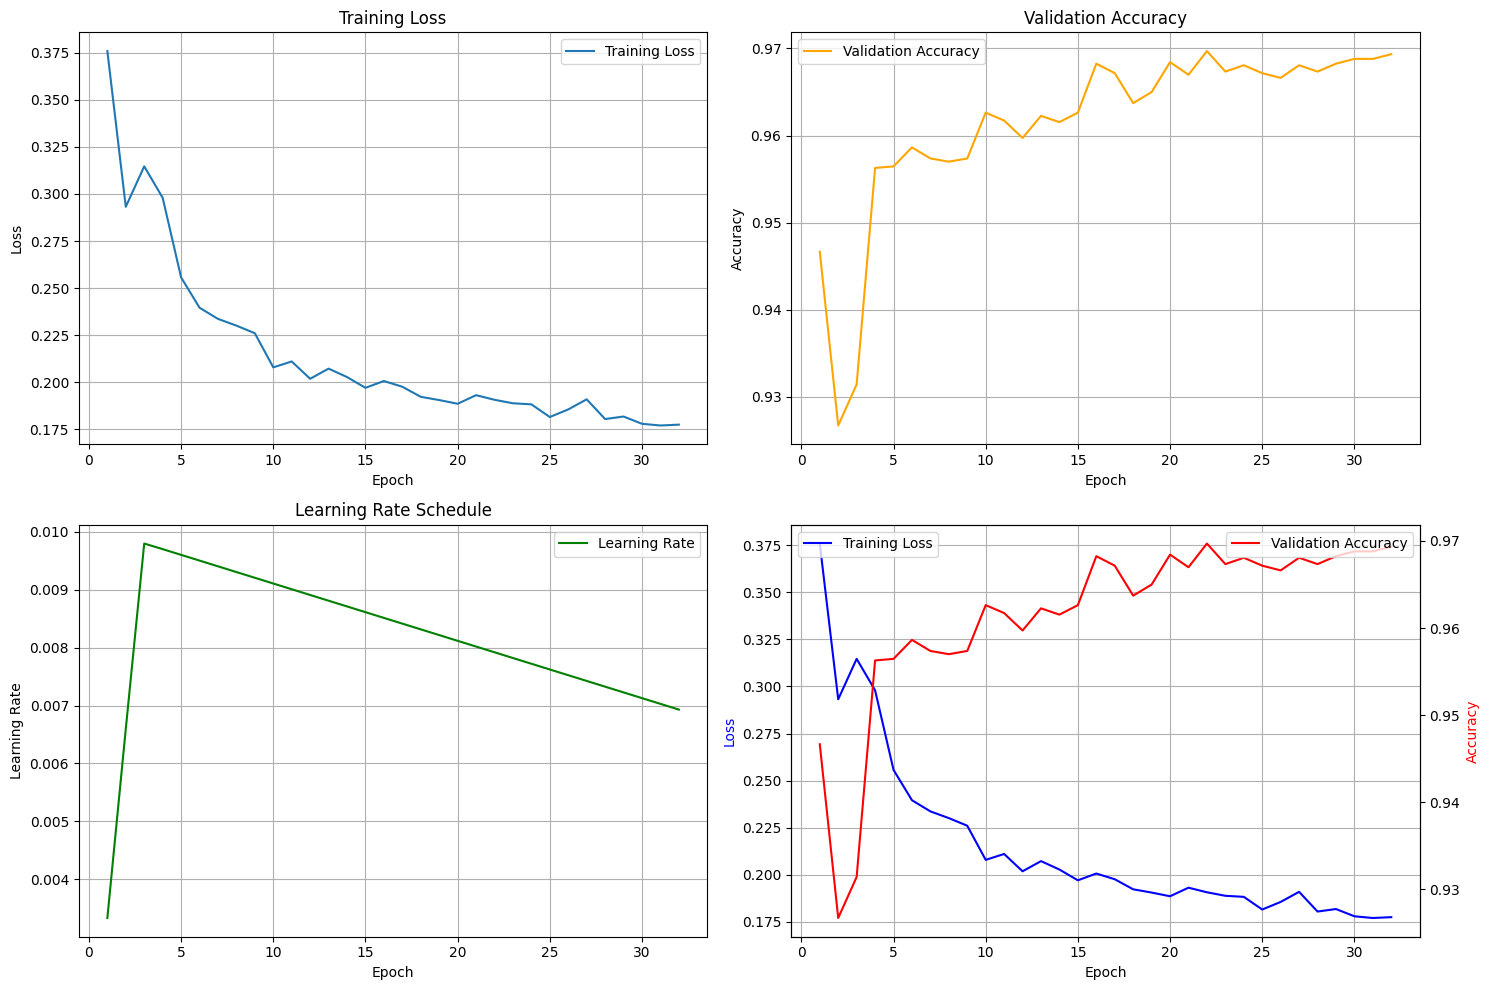

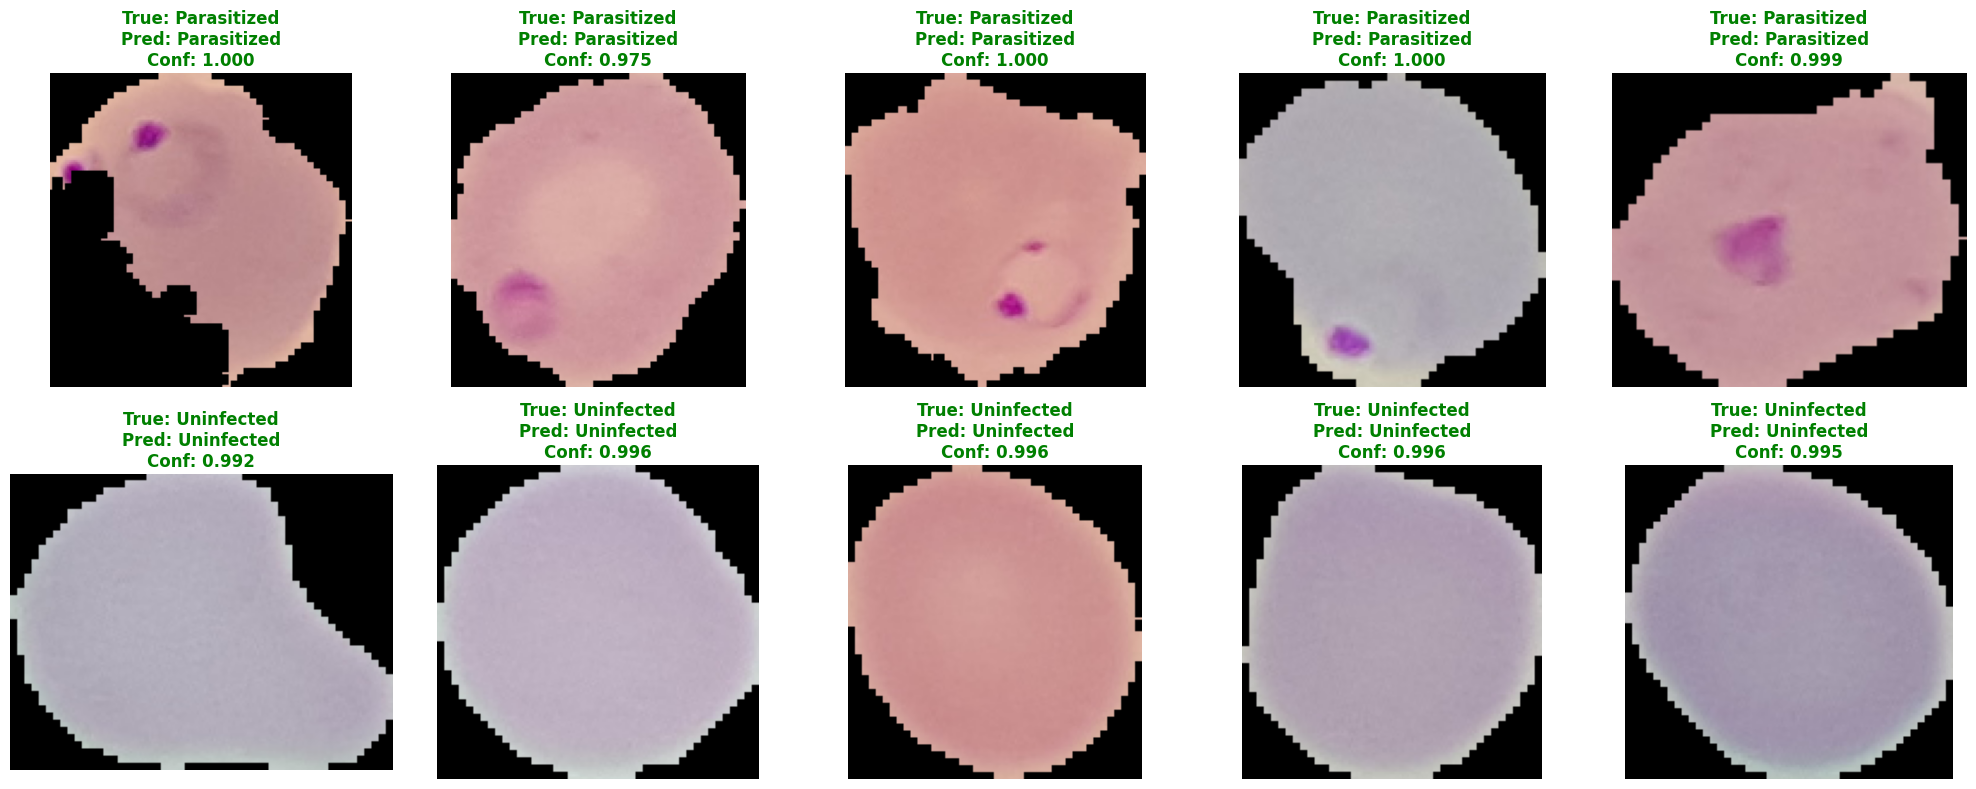

Exporting model for deployment...
Exporting to ONNX...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'runs/classify/train4/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 2) (2.8 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.59', 'onnxruntime-gpu'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 6.2s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.59...
ONNX: export success ✅ 6.9s, saved as 'runs/classify/train4/weights/best.onnx' (5.5 MB)

Export complete (7.1s)
Results saved to /content/drive/MyDrive/hackathon/runs/classify/train4/weights
Predict:         yolo predict task=cl

100%|██████████| 1.11M/1.11M [00:00<00:00, 44.1MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/drive/MyDrive/hackathon/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 25.18file/s]


ONNX: starting export with onnx 1.17.0 opset 19...


ONNX: slimming with onnxslim 0.1.59...
ONNX: export success ✅ 0.5s, saved as 'runs/classify/train4/weights/best.onnx' (5.5 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.28.1...
Saved artifact at 'runs/classify/train4/weights/best_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 224, 224, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 2), dtype=tf.float32, name=None)
Captures:
  139401830484496: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  139401854712144: TensorSpec(shape=(3, 3, 3, 16), dtype=tf.float32, name=None)
  139401830486800: TensorSpec(shape=(16,), dtype=tf.float32, name=None)
  139401830493520: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  139401830493136: TensorSpec(shape=(3, 3, 16, 32), dtype=tf.float32, name=None)
  139401830494096: TensorSpec(shape=(32,), dtype=tf.float32, name=None)
  139401830490832: TensorSpec(shape=(1, 1, 3


CoreML: starting export with coremltools 8.3.0...


Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 208.33 passes/s]


CoreML: export success ✅ 10.5s, saved as 'runs/classify/train4/weights/best.mlpackage' (2.8 MB)

Export complete (10.7s)
Results saved to /content/drive/MyDrive/hackathon/runs/classify/train4/weights
Predict:         yolo predict task=classify model=runs/classify/train4/weights/best.mlpackage imgsz=224  
Validate:        yolo val task=classify model=runs/classify/train4/weights/best.mlpackage imgsz=224 data=/content/drive/MyDrive/hackathon/datasets  
Visualize:       https://netron.app
✅ CoreML model exported successfully
Exporting to Paddle...
Ultralytics 8.3.167 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/classify/train4/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 2) (2.8 MB)
requirements: Ultralytics requirements ['paddlepaddle-gpu', 'x2paddle'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 48.3s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take eff

INFO:x2paddle.convert:Now translating model from PyTorch to Paddle.
INFO:x2paddle.convert:Model optimizing ...
INFO:x2paddle.convert:Model optimized!


Exporting inference model from python code ('/content/drive/MyDrive/hackathon/runs/classify/train4/weights/best_paddle_model/x2paddle_code.py')... 



INFO:x2paddle.convert:Successfully exported Paddle static graph model!
INFO:x2paddle.convert:================================================
INFO:x2paddle.convert:
INFO:x2paddle.convert:Model Converted! Fill this survey to help X2Paddle better, https://iwenjuan.baidu.com/?code=npyd51 
INFO:x2paddle.convert:
INFO:x2paddle.convert:================================================


PaddlePaddle: export success ✅ 54.0s, saved as 'runs/classify/train4/weights/best_paddle_model/' (11.1 MB)

Export complete (54.1s)
Results saved to /content/drive/MyDrive/hackathon/runs/classify/train4/weights
Predict:         yolo predict task=classify model=runs/classify/train4/weights/best_paddle_model imgsz=224  
Validate:        yolo val task=classify model=runs/classify/train4/weights/best_paddle_model imgsz=224 data=/content/drive/MyDrive/hackathon/datasets  
Visualize:       https://netron.app
✅ Paddle model exported successfully

📊 Export Summary:
✅ Successful exports: 6
   - ONNX
   - TensorFlow Lite
   - TensorRT
   - OpenVINO
   - CoreML
   - Paddle

🔬 MALARIA DETECTION MODEL - COMPREHENSIVE REPORT

📊 PERFORMANCE METRICS:
   Test Accuracy:     0.9637 (96.37%)
   Precision:         0.9776 (97.76%)
   Recall:            0.9492 (94.92%)
   F1-Score:          0.9632 (96.32%)

🏥 CLINICAL INTERPRETATION:
   Sensitivity:       0.9492 (Detects 94.9% of infected cases)
   Specifici

In [30]:
# Fixed Model Evaluation Script with Proper Column Names

import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO
import os
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import torch
import pandas as pd
import cv2

# Load your trained model
model_path = "runs/classify/train4/weights/best.pt"
model = YOLO(model_path)

# 1. Evaluate on test set
def evaluate_test_set():
    """Evaluate the trained model on test set"""
    print("Evaluating on test set...")

    # Test on the test split
    test_results = model.val(data='/content/drive/MyDrive/hackathon/datasets',
                           split='test')

    print(f"Test Accuracy: {test_results.top1:.4f}")
    print(f"Test Loss: {test_results.fitness:.4f}")

    return test_results

# 2. Create detailed confusion matrix
def create_confusion_matrix():
    """Create confusion matrix for test set"""
    test_dir = '/content/drive/MyDrive/hackathon/datasets/test'

    y_true = []
    y_pred = []
    confidences = []

    print("Processing Parasitized images...")
    # Test on Parasitized images
    parasitized_dir = os.path.join(test_dir, 'Parasitized')
    for img_name in os.listdir(parasitized_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(parasitized_dir, img_name)
            results = model(img_path, verbose=False)

            predicted_class = results[0].names[results[0].probs.top1]
            confidence = results[0].probs.top1conf.item()

            y_true.append('Parasitized')
            y_pred.append(predicted_class)
            confidences.append(confidence)

    print("Processing Uninfected images...")
    # Test on Uninfected images
    uninfected_dir = os.path.join(test_dir, 'Uninfected')
    for img_name in os.listdir(uninfected_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(uninfected_dir, img_name)
            results = model(img_path, verbose=False)

            predicted_class = results[0].names[results[0].probs.top1]
            confidence = results[0].probs.top1conf.item()

            y_true.append('Uninfected')
            y_pred.append(predicted_class)
            confidences.append(confidence)

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=['Parasitized', 'Uninfected'])

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Parasitized', 'Uninfected'],
                yticklabels=['Parasitized', 'Uninfected'])
    plt.title('Confusion Matrix - Malaria Classification\nTest Set Results')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label='Parasitized')
    recall = recall_score(y_true, y_pred, pos_label='Parasitized')
    f1 = f1_score(y_true, y_pred, pos_label='Parasitized')

    print(f"\nTest Set Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Average Confidence: {np.mean(confidences):.4f}")

    return cm, accuracy, precision, recall, f1

# 3. Fixed training progress visualization
def plot_training_progress():
    """Plot training curves from results with proper column names"""

    # Load training results
    results_path = "runs/classify/train4/results.csv"
    if os.path.exists(results_path):
        df = pd.read_csv(results_path)

        # Print available columns to debug
        print("Available columns in results.csv:")
        print(df.columns.tolist())

        # Map common column variations
        column_mapping = {
            'val/acc_top1': ['val/acc_top1', 'metrics/accuracy_top1', 'val_accuracy', 'accuracy'],
            'train/loss': ['train/loss', 'train_loss', 'loss'],
            'lr/pg0': ['lr/pg0', 'lr', 'learning_rate', 'lr0']
        }

        # Find correct column names
        actual_columns = {}
        for key, possible_names in column_mapping.items():
            for name in possible_names:
                if name in df.columns:
                    actual_columns[key] = name
                    break

        print("Mapped columns:", actual_columns)

        # Create plots with available data
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Training loss
        if 'train/loss' in actual_columns:
            axes[0,0].plot(df['epoch'], df[actual_columns['train/loss']], label='Training Loss')
            axes[0,0].set_title('Training Loss')
            axes[0,0].set_xlabel('Epoch')
            axes[0,0].set_ylabel('Loss')
            axes[0,0].legend()
            axes[0,0].grid(True)
        else:
            axes[0,0].text(0.5, 0.5, 'Training Loss\nData Not Available',
                          ha='center', va='center', transform=axes[0,0].transAxes)

        # Validation accuracy
        if 'val/acc_top1' in actual_columns:
            axes[0,1].plot(df['epoch'], df[actual_columns['val/acc_top1']], label='Validation Accuracy', color='orange')
            axes[0,1].set_title('Validation Accuracy')
            axes[0,1].set_xlabel('Epoch')
            axes[0,1].set_ylabel('Accuracy')
            axes[0,1].legend()
            axes[0,1].grid(True)
        else:
            axes[0,1].text(0.5, 0.5, 'Validation Accuracy\nData Not Available',
                          ha='center', va='center', transform=axes[0,1].transAxes)

        # Learning rate
        if 'lr/pg0' in actual_columns:
            axes[1,0].plot(df['epoch'], df[actual_columns['lr/pg0']], label='Learning Rate', color='green')
            axes[1,0].set_title('Learning Rate Schedule')
            axes[1,0].set_xlabel('Epoch')
            axes[1,0].set_ylabel('Learning Rate')
            axes[1,0].legend()
            axes[1,0].grid(True)
        else:
            axes[1,0].text(0.5, 0.5, 'Learning Rate\nData Not Available',
                          ha='center', va='center', transform=axes[1,0].transAxes)

        # Combined loss and accuracy
        if 'train/loss' in actual_columns and 'val/acc_top1' in actual_columns:
            ax2 = axes[1,1].twinx()
            axes[1,1].plot(df['epoch'], df[actual_columns['train/loss']], 'b-', label='Training Loss')
            ax2.plot(df['epoch'], df[actual_columns['val/acc_top1']], 'r-', label='Validation Accuracy')

            axes[1,1].set_xlabel('Epoch')
            axes[1,1].set_ylabel('Loss', color='b')
            ax2.set_ylabel('Accuracy', color='r')
            axes[1,1].legend(loc='upper left')
            ax2.legend(loc='upper right')
            axes[1,1].grid(True)
        else:
            axes[1,1].text(0.5, 0.5, 'Combined Plot\nData Not Available',
                          ha='center', va='center', transform=axes[1,1].transAxes)

        plt.tight_layout()
        plt.show()
    else:
        print(f"Results file not found: {results_path}")

# 4. Test on sample images
def test_sample_predictions():
    """Test model on sample images"""
    test_dir = '/content/drive/MyDrive/hackathon/datasets/test'

    # Get sample images
    parasitized_imgs = os.listdir(os.path.join(test_dir, 'Parasitized'))[:5]
    uninfected_imgs = os.listdir(os.path.join(test_dir, 'Uninfected'))[:5]

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    # Test parasitized images
    for i, img_name in enumerate(parasitized_imgs):
        img_path = os.path.join(test_dir, 'Parasitized', img_name)
        results = model(img_path, verbose=False)

        predicted_class = results[0].names[results[0].probs.top1]
        confidence = results[0].probs.top1conf.item()

        # Load and display image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[0,i].imshow(img)
        color = 'green' if predicted_class == 'Parasitized' else 'red'
        axes[0,i].set_title(f'True: Parasitized\nPred: {predicted_class}\nConf: {confidence:.3f}',
                           color=color, fontweight='bold')
        axes[0,i].axis('off')

    # Test uninfected images
    for i, img_name in enumerate(uninfected_imgs):
        img_path = os.path.join(test_dir, 'Uninfected', img_name)
        results = model(img_path, verbose=False)

        predicted_class = results[0].names[results[0].probs.top1]
        confidence = results[0].probs.top1conf.item()

        # Load and display image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[1,i].imshow(img)
        color = 'green' if predicted_class == 'Uninfected' else 'red'
        axes[1,i].set_title(f'True: Uninfected\nPred: {predicted_class}\nConf: {confidence:.3f}',
                           color=color, fontweight='bold')
        axes[1,i].axis('off')

    plt.tight_layout()
    plt.show()

# 5. Enhanced model export with error handling
def export_model():
    """Export model for different deployment scenarios"""
    print("Exporting model for deployment...")

    export_formats = [
        ('onnx', 'ONNX'),
        ('tflite', 'TensorFlow Lite'),
        ('engine', 'TensorRT'),
        ('openvino', 'OpenVINO'),
        ('coreml', 'CoreML'),
        ('paddle', 'Paddle')
    ]

    successful_exports = []
    failed_exports = []

    for format_name, display_name in export_formats:
        try:
            print(f"Exporting to {display_name}...")
            model.export(format=format_name, imgsz=224)
            successful_exports.append(display_name)
            print(f"✅ {display_name} model exported successfully")
        except Exception as e:
            failed_exports.append((display_name, str(e)))
            print(f"❌ {display_name} export failed: {e}")

    print(f"\n📊 Export Summary:")
    print(f"✅ Successful exports: {len(successful_exports)}")
    for export in successful_exports:
        print(f"   - {export}")

    if failed_exports:
        print(f"❌ Failed exports: {len(failed_exports)}")
        for export, error in failed_exports:
            print(f"   - {export}: {error}")

# 6. Enhanced production inference function
def create_production_inference():
    """Create optimized inference function for production"""

    def predict_malaria(image_path, threshold=0.5):
        """
        Predict malaria from cell image

        Args:
            image_path: Path to the cell image
            threshold: Confidence threshold for prediction

        Returns:
            dict: Prediction results
        """
        try:
            results = model(image_path, verbose=False)

            predicted_class = results[0].names[results[0].probs.top1]
            confidence = results[0].probs.top1conf.item()

            # Get all probabilities
            probs = results[0].probs.data.cpu().numpy()
            class_names = list(results[0].names.values())

            # Determine if prediction is reliable
            is_reliable = confidence >= threshold

            # Medical recommendation based on prediction
            if predicted_class == 'Parasitized':
                if confidence > 0.95:
                    recommendation = 'High confidence malaria detection. Immediate medical attention recommended.'
                    risk_level = 'high'
                elif confidence > 0.8:
                    recommendation = 'Possible malaria infection detected. Consult healthcare provider.'
                    risk_level = 'medium'
                else:
                    recommendation = 'Low confidence detection. Manual examination recommended.'
                    risk_level = 'low'
            else:
                if confidence > 0.95:
                    recommendation = 'No malaria parasites detected with high confidence.'
                    risk_level = 'low'
                elif confidence > 0.8:
                    recommendation = 'Likely no malaria infection. Monitor symptoms.'
                    risk_level = 'low'
                else:
                    recommendation = 'Uncertain result. Consider retesting or manual examination.'
                    risk_level = 'medium'

            return {
                'prediction': predicted_class,
                'confidence': confidence,
                'all_probabilities': {class_names[i]: float(probs[i]) for i in range(len(class_names))},
                'is_reliable': is_reliable,
                'recommendation': recommendation,
                'risk_level': risk_level
            }

        except Exception as e:
            return {
                'error': str(e),
                'prediction': None,
                'confidence': 0.0,
                'is_reliable': False,
                'recommendation': 'Error in prediction. Please try again.',
                'risk_level': 'error'
            }

    return predict_malaria

# 7. Create comprehensive model report
def create_model_report(accuracy, precision, recall, f1):
    """Create a comprehensive model performance report"""
    print("\n" + "="*60)
    print("🔬 MALARIA DETECTION MODEL - COMPREHENSIVE REPORT")
    print("="*60)

    print(f"\n📊 PERFORMANCE METRICS:")
    print(f"   Test Accuracy:     {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision:         {precision:.4f} ({precision*100:.2f}%)")
    print(f"   Recall:            {recall:.4f} ({recall*100:.2f}%)")
    print(f"   F1-Score:          {f1:.4f} ({f1*100:.2f}%)")

    print(f"\n🏥 CLINICAL INTERPRETATION:")
    print(f"   Sensitivity:       {recall:.4f} (Detects {recall*100:.1f}% of infected cases)")
    print(f"   Specificity:       {1-precision:.4f} (Correctly identifies {(1-precision)*100:.1f}% of uninfected)")
    print(f"   PPV (Precision):   {precision:.4f} ({precision*100:.1f}% of positive predictions are correct)")

    print(f"\n🎯 MEDICAL READINESS:")
    if accuracy > 0.95 and recall > 0.94:
        print("   ✅ EXCELLENT - Ready for clinical assistance")
    elif accuracy > 0.90 and recall > 0.90:
        print("   ✅ GOOD - Suitable for screening with oversight")
    else:
        print("   ⚠️  NEEDS IMPROVEMENT - Not ready for clinical use")

    print(f"\n📱 DEPLOYMENT RECOMMENDATIONS:")
    print("   - Use as screening tool with medical oversight")
    print("   - Implement confidence thresholds for uncertain cases")
    print("   - Provide clear medical disclaimers")
    print("   - Enable human-in-the-loop for low confidence predictions")

    print("\n" + "="*60)

# Run all evaluations
if __name__ == "__main__":
    print("🔬 Starting Post-Training Evaluation...")

    # 1. Test set evaluation
    test_results = evaluate_test_set()

    # 2. Confusion matrix
    cm, accuracy, precision, recall, f1 = create_confusion_matrix()

    # 3. Plot training progress (with fixed column names)
    plot_training_progress()

    # 4. Sample predictions
    test_sample_predictions()

    # 5. Export model
    export_model()

    # 6. Create production function
    predict_malaria = create_production_inference()

    # 7. Create comprehensive report
    create_model_report(accuracy, precision, recall, f1)

    print(f"\n🎉 Evaluation Complete!")
    print(f"Model saved at: {model_path}")
    print(f"Ready for deployment! 🚀")